# ***Network Intrusion Detection System Using Machine Learning***

---



---





# Import Relevant Modules 

In [1]:
! pip install pygam


     |████████████████████████████████| 1.8MB 2.8MB/s 


In [2]:
!pip install ipython-autotime

%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=3559fce8951a55f3f0ee8da4c9383ce01ab12e6cd90979543ad3538259cceaaf
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import imblearn

time: 660 ms


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
import warnings
warnings.filterwarnings('ignore')

time: 1.34 ms


In [5]:
# Libraries

print("pandas : {0}".format(pd.__version__))
print("numpy : {0}".format(np.__version__))
print("matplotlib : {0}".format(matplotlib.__version__))
print("seaborn : {0}".format(sns.__version__))
print("sklearn : {0}".format(sklearn.__version__))
print("imblearn : {0}".format(imblearn.__version__))

pandas : 1.0.5
numpy : 1.18.5
matplotlib : 3.2.2
seaborn : 0.10.1
sklearn : 0.22.2.post1
imblearn : 0.4.3
time: 5.04 ms


# Loading Training And Testing Data

In [6]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Test.txt to Test.txt
Saving Train.txt to Train.txt
User uploaded file "Test.txt" with length 3441513 bytes
User uploaded file "Train.txt" with length 19109423 bytes
time: 8min 35s


In [7]:
# Dataset field names

field_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]

time: 5.65 ms


In [8]:
# Loading Train Dataset
train_data = pd.read_table("Train.txt", sep=",", names=field_names)
# Removes an unwanted extra field
train_data = train_data.iloc[:,:-1] 

# Loading Test Dataset
test_data = pd.read_table("Test.txt", sep=",", names=field_names)
# Removes an unwanted extra field
test_data = test_data.iloc[:,:-1]

time: 524 ms


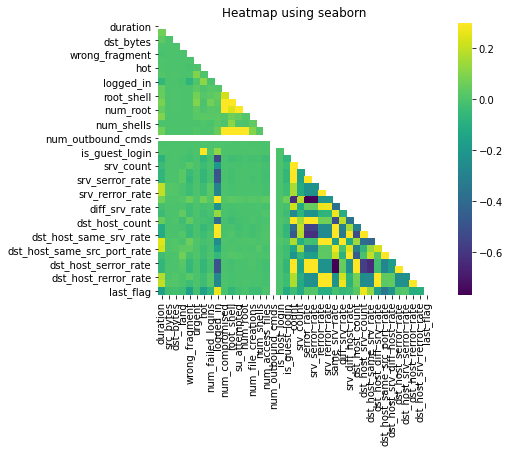

time: 1.66 s


In [9]:
data = pd.read_table("Train.txt", sep=",", names=field_names)

corr = data.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig = plt.figure(figsize = (10, 5))

ax = sns.heatmap(corr, 
                 mask = mask, 
                 vmax = 0.3, 
                 square = True,  
                 cmap = "viridis")

ax.set_title("Heatmap using seaborn");

# Preview of Training And Testing Data

In [10]:
# Preview of Training Data
train_data.head(4)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.0,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.0,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.0,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.0,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal


time: 80.5 ms


In [11]:
# Set Dimensions For Training Data
print('Train set dimension: {} rows, {} columns'.format(train_data.shape[0], train_data.shape[1]))

Train set dimension: 125973 rows, 42 columns
time: 1.62 ms


In [12]:
# Preview of Testing Data
test_data.head(4)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.0,0.0,1.0,1.0,0.04,0.06,0.0,255,10,0.04,0.06,0.00,0.00,0.0,0.0,1.0,1.0,neptune
1,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.0,1.0,1.0,0.01,0.06,0.0,255,1,0.00,0.06,0.00,0.00,0.0,0.0,1.0,1.0,neptune
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.0,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.0,0.0,normal
3,0,icmp,eco_i,SF,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.0,0.0,0.0,0.0,1.00,0.00,1.0,3,57,1.00,0.00,1.00,0.28,0.0,0.0,0.0,0.0,saint


time: 76.3 ms


In [13]:
# Set Dimensions For Training Data
print('Test set dimension: {} rows, {} columns'.format(test_data.shape[0], test_data.shape[1]))

Test set dimension: 22544 rows, 42 columns
time: 1.74 ms


# Data Preprocessing

Mapping Different Attacks into 4 Major Attack Classes:

1.   Denial of Service (DoS)
2.   Probing Attack (Probe)
3.   User to Root Attack (U2R)
4.   Remote to Local Attack (R2L)



In [14]:
map = {'ipsweep': 'Probe','satan': 'Probe','nmap': 'Probe','portsweep': 'Probe','saint': 'Probe','mscan': 'Probe',
        'teardrop': 'DoS','pod': 'DoS','land': 'DoS','back': 'DoS','neptune': 'DoS','smurf': 'DoS','mailbomb': 'DoS',
        'udpstorm': 'DoS','apache2': 'DoS','processtable': 'DoS',
        'perl': 'U2R','loadmodule': 'U2R','rootkit': 'U2R','buffer_overflow': 'U2R','xterm': 'U2R','ps': 'U2R',
        'sqlattack': 'U2R','httptunnel': 'U2R',
        'ftp_write': 'R2L','phf': 'R2L','guess_passwd': 'R2L','warezmaster': 'R2L','warezclient': 'R2L','imap': 'R2L',
        'spy': 'R2L','multihop': 'R2L','named': 'R2L','snmpguess': 'R2L','worm': 'R2L','snmpgetattack': 'R2L',
        'xsnoop': 'R2L','xlock': 'R2L','sendmail': 'R2L',
        'normal': 'Normal'
        }

time: 8.47 ms


In [15]:
# Apply attack class mappings to the dataset
train_data['attack_class'] = train_data['attack'].apply(lambda v: map[v])
test_data['attack_class'] = test_data['attack'].apply(lambda v: map[v])

time: 42.2 ms


In [16]:
# Drop attack field from both train and test data
train_data.drop(['attack'], axis=1, inplace=True)
test_data.drop(['attack'], axis=1, inplace=True)

time: 32.6 ms


In [17]:
# Preview of top 4 Train Data 
train_data.head(4)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.0,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,Normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.0,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,Normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.0,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,DoS
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.0,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,Normal


time: 81 ms


In [18]:
# Descriptive statistics
da = train_data.describe()
da

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.0,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,0.001342,0.001103,0.302192,0.012669,0.000413,0.004096,0.0,0.000008,0.009423,84.107555,27.737888,0.284485,0.282485,0.119958,0.121183,0.660928,0.063053,0.097322,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,0.036603,0.045154,24.399618,0.483935,0.022181,0.099370,0.0,0.002817,0.096612,114.508607,72.635840,0.446456,0.447022,0.320436,0.323647,0.439623,0.180314,0.259830,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,143.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,43.000000,2.000000,9.000000,0.0,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


time: 302 ms


In [19]:
train_data['num_outbound_cmds'].value_counts()

0    125973
Name: num_outbound_cmds, dtype: int64

time: 8 ms


In [20]:
test_data['num_outbound_cmds'].value_counts()

0    22544
Name: num_outbound_cmds, dtype: int64

time: 6.2 ms


In [21]:
train_data.drop(['num_outbound_cmds'], axis=1, inplace=True)

time: 17.6 ms


In [22]:
test_data.drop(['num_outbound_cmds'], axis=1, inplace=True)

time: 7.52 ms


In [57]:
# Attack Class Distribution
atk_train = train_data[['attack_class']].apply(lambda x: x.value_counts())
atk_test = test_data[['attack_class']].apply(lambda x: x.value_counts())
atk_train['frequency_train_percent'] = round((100 * atk_train / atk_train.sum()),2)
atk_test['frequency_test_percent'] = round((100 * atk_test / atk_test.sum()),2)

atk_dist = pd.concat([atk_train,atk_test], axis=1) 
atk_dist

,attack_class,frequency_train_percent,attack_class,frequency_test_percent
Normal,67343,53.46,9711,43.08
DoS,45927,36.46,7458,33.08
Probe,11656,9.25,2421,10.74
R2L,995,0.79,2754,12.22
U2R,52,0.04,200,0.89


time: 67 ms


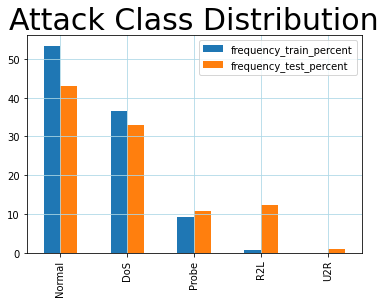

time: 210 ms


In [24]:
# Attack class bar plot
plot = atk_dist[['frequency_train_percent', 'frequency_test_percent']].plot(kind="bar");
plot.set_title("Attack Class Distribution", fontsize=30);
plot.grid(color='lightblue', alpha=1.0);

In [25]:
train_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,Normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,Normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,DoS
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,Normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Normal


time: 70.7 ms


In [26]:
# Scaling numerical Attributes

from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

# extract numerical attributes from data and scale it to have zero mean and unit variance  
clmns = train_data.select_dtypes(include=['float64','int64']).columns
scaler_train = std_scaler.fit_transform(train_data.select_dtypes(include=['float64','int64']))
scaler_test = std_scaler.fit_transform(test_data.select_dtypes(include=['float64','int64']))

# turn the result back to a dataframe
scaler_train_frame = pd.DataFrame(scaler_train, columns = clmns)
scaler_test_frame = pd.DataFrame(scaler_test, columns = clmns)

time: 205 ms


In [27]:
# Encoding of Categorical Attributes

from sklearn.preprocessing import LabelEncoder
l_encoder = LabelEncoder()

# extracting the categorical attributes from both training and testing  datasets 
categorical_train = train_data.select_dtypes(include=['object']).copy()
categorical_test = test_data.select_dtypes(include=['object']).copy()

# encoding the categorical attributes
train_categorical = categorical_train.apply(l_encoder.fit_transform)
test_categorical = categorical_test.apply(l_encoder.fit_transform)

# separating target column from encoded data 
encode_train = train_categorical.drop(['attack_class'], axis=1)
encode_test = test_categorical.drop(['attack_class'], axis=1)

categorical_Ytrain = train_categorical[['attack_class']].copy()
categorical_Ytest = test_categorical[['attack_class']].copy()

time: 157 ms


In [28]:
# Data Sampling

from imblearn.over_sampling import RandomOverSampler 
from collections import Counter

# defining columns and extracting encoded train dataset for sampling 
scaler_train_frame = train_data.select_dtypes(include=['float64','int64'])
ref_class_column = pd.concat([scaler_train_frame, encode_train], axis=1).columns
ref_class = np.concatenate((scaler_train, encode_train.values), axis=1)
X = ref_class

# reshaping target column to 1D array shape  
c, r = categorical_Ytest.values.shape
y_test = categorical_Ytest.values.reshape(c,)

c, r = categorical_Ytrain.values.shape
y = categorical_Ytrain.values.reshape(c,)

# applying the random over-sampling
sampling = RandomOverSampler(random_state=42)
X_res, y_res = sampling.fit_sample(X, y)
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({1: 67343, 0: 45927, 2: 11656, 3: 995, 4: 52})
Resampled dataset shape Counter({1: 67343, 0: 67343, 3: 67343, 2: 67343, 4: 67343})
time: 324 ms


# Feature Selection Using RandomForest Classifier Model 

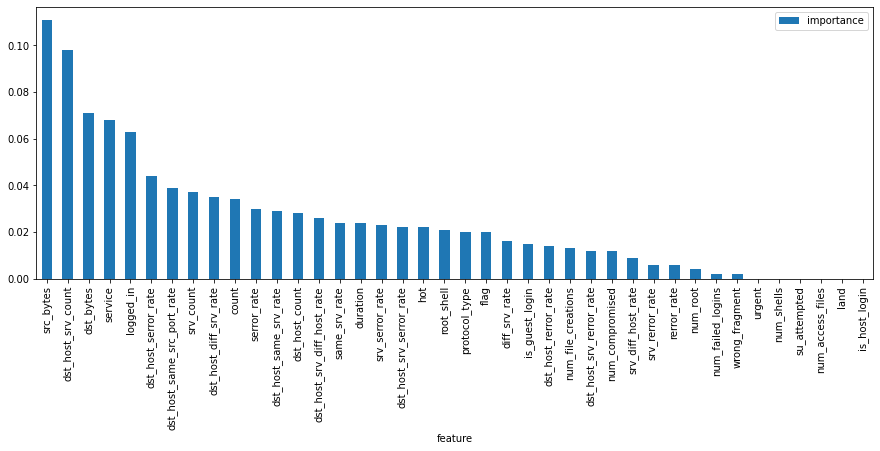

time: 31 s


In [29]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier();

# fitting random forest classifier on the training set
random_forest.fit(X_res, y_res);
# extracting important features
scoring = np.round(random_forest.feature_importances_,3)
important = pd.DataFrame({'feature':ref_class_column,'importance':scoring})
important = important.sort_values('importance',ascending=False).set_index('feature')
# plotting important features in bar graph
plt.rcParams['figure.figsize'] = (15, 5)
important.plot.bar();

In [30]:
from sklearn.feature_selection import RFE
import itertools
random_forest = RandomForestClassifier()

# creating the RFE model and selecting 10 attributes
random_feature = RFE(random_forest, n_features_to_select=10)
random_forest = random_feature.fit(X_res, y_res)

# summarizing the selection of the attributes
feature_mapping = [(j, w) for j, w in itertools.zip_longest(random_feature.get_support(), ref_class_column)]
features = [w for j, w in feature_mapping if j==True]

time: 14min 2s


In [31]:
features

['src_bytes',
 'dst_bytes',
 'logged_in',
 'count',
 'srv_count',
 'dst_host_srv_count',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_serror_rate',
 'service']

time: 5.07 ms


# Dataset Partition

In [32]:
# defining columns to a new dataframe
new_column = list(ref_class_column)
new_column.append('attack_class')

# adding a dimension to target
new_y_res = y_res[:, np.newaxis]

# creating a dataframe from sampled data
res_array = np.concatenate((X_res, new_y_res), axis=1)
res_data_frame = pd.DataFrame(res_array, columns = new_column) 

# creating test dataframe
test_ref = pd.concat([scaler_test_frame, test_categorical], axis=1)
test_ref['attack_class'] = test_ref['attack_class'].astype(np.float64)
test_ref['protocol_type'] = test_ref['protocol_type'].astype(np.float64)
test_ref['flag'] = test_ref['flag'].astype(np.float64)
test_ref['service'] = test_ref['service'].astype(np.float64)

res_data_frame.shape


(336715, 41)

time: 53 ms


In [33]:
test_ref.shape

(22544, 41)

time: 5.35 ms


In [34]:
from collections import defaultdict
class_dict = defaultdict(list)

# creating two-target classes: normal class and an attack class
atk_list = [('DoS', 0.0), ('Probe', 2.0), ('R2L', 3.0), ('U2R', 4.0)]
nrml_class = [('Normal', 1.0)]

def create_class_dict():
    '''This function subdivides train and test dataset into two-class attack labels''' 
    for i, l in nrml_class: 
        for j, w in atk_list: 
            res_train_set = res_data_frame.loc[(res_data_frame['attack_class'] == l) | (res_data_frame['attack_class'] == w)]
            class_dict[i +'_' + j].append(res_train_set)
            # test labels
            ref_test_set = test_ref.loc[(test_ref['attack_class'] == l) | (test_ref['attack_class'] == w)]
            class_dict[i +'_' + j].append(ref_test_set)
        
create_class_dict()

time: 177 ms


In [35]:
pre_train = class_dict['Normal_DoS'][0]
pre_test = class_dict['Normal_DoS'][0]
group_class = 'Normal_DoS'

time: 2.16 ms


In [36]:
# Finalizing data preprocessing for training

from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder()

X_res_data_frame = pre_train 
new_test = pre_test

X_res_data_frame_new = X_res_data_frame[features]
X_res_data_frame_num = X_res_data_frame_new.drop(['service'], axis=1)
X_res_data_frame_cat = X_res_data_frame_new[['service']].copy()

X_test_features = new_test[features]
X_test_data_frame_num = X_test_features.drop(['service'], axis=1)
X_test_cat = X_test_features[['service']].copy()

# Fitting training data
one_hot_encoder.fit(X_res_data_frame_cat)

# Transforming training data
X_train_one_hotencoder = one_hot_encoder.transform(X_res_data_frame_cat).toarray()
       
# Transforming testing data
X_test_one_hotencoder = one_hot_encoder.transform(X_test_cat).toarray()

X_train_dataframe = np.concatenate((X_res_data_frame_num.values, X_train_one_hotencoder), axis=1)
X_test_dataframe = np.concatenate((X_test_data_frame_num.values, X_test_one_hotencoder), axis=1) 

y_train_dataframe = X_res_data_frame[['attack_class']].copy()
c, r = y_train_dataframe.values.shape
Y_train_dataframe = y_train_dataframe.values.reshape(c,)

y_test_dataframe = new_test[['attack_class']].copy()
c, r = y_test_dataframe.values.shape
Y_test_dataframe = y_test_dataframe.values.reshape(c,)


time: 307 ms


# Training Using pyGAM And Different Classifier Models



In [37]:
from pygam import LogisticGAM
import time
# Logistic GAM
Logistic_gam = LogisticGAM()
Logistic_gam.fit(X_train_dataframe, Y_train_dataframe);


time: 33min 31s


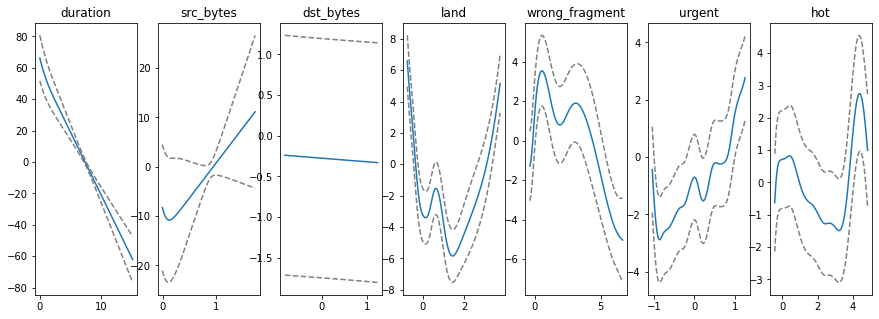

time: 953 ms


In [38]:
fig, axs = plt.subplots(1, 7)
titles = ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot']

for i, w in enumerate(axs):
    u = Logistic_gam.generate_X_grid(term=i)
    pdep, confi = Logistic_gam.partial_dependence(term=i, width=.95)

    w.plot(u[:, i], pdep)
    w.plot(u[:, i], confi, c='grey', ls='--')
    w.set_title(titles[i]);

In [39]:
from sklearn.svm import SVC 
from sklearn.naive_bayes import BernoulliNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

time: 32.2 ms


In [40]:
# Train KNeighbors Classifier Model

KNeighbors_Classifier = KNeighborsClassifier(n_jobs=-1)
KNeighbors_Classifier.fit(X_train_dataframe, Y_train_dataframe); 

time: 3.19 s


In [41]:
# Train Gaussian Naive Baye Model

Naive_Baye_Classifier = BernoulliNB()
Naive_Baye_Classifier.fit(X_train_dataframe, Y_train_dataframe)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

time: 155 ms


In [42]:
# Train Support Vector Machine Model

Support_vector_Classifier = SVC(random_state=0)
Support_vector_Classifier.fit(X_train_dataframe, Y_train_dataframe)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

time: 2min 49s


In [43]:
# Train RandomForestClassifier Model

Random_Forest_Classifier = RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=0)
Random_Forest_Classifier.fit(X_train_dataframe, Y_train_dataframe); 

time: 11.2 s


In [44]:
# Train Combined Models 1

model1 = [('Random Forest Classifier', Random_Forest_Classifier), ('KNN Classifier', KNeighbors_Classifier)]
model_1 = VotingClassifier(estimators = model1,voting = 'soft', n_jobs=-1)
model_1.fit(X_train_dataframe, Y_train_dataframe);

time: 19 s


In [45]:
# Train Combined Models 2

model2 = [('Random Forest Classifier', Random_Forest_Classifier), ('Gaussian Naive Baye Classifier', Naive_Baye_Classifier)]
model_2 = VotingClassifier(estimators = model2,voting = 'soft', n_jobs=-1)
model_2.fit(X_train_dataframe, Y_train_dataframe);

time: 11.6 s


# AUC-ROC Curve

No Skill: ROC AUC=0.500
Logistic: ROC AUC=1.000


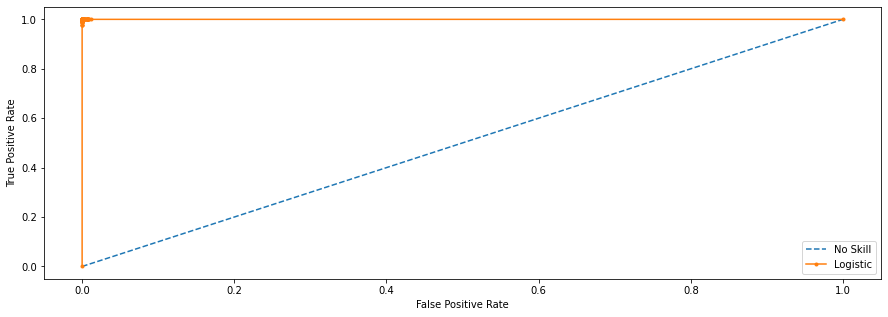

time: 1min 9s


In [58]:
# ROC curve for Random Forest Classifier and KNN Classifier


from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

probability1 = [0 for _ in range(len(Y_test_dataframe))]

probability2 = model_1.predict_proba(X_test_dataframe)
probability2 = probability2[:, 1]

auc1 = roc_auc_score(Y_test_dataframe, probability1)
auc2 = roc_auc_score(Y_test_dataframe, probability2)

print('No Skill: ROC AUC=%.3f' % (auc1))
print('Logistic: ROC AUC=%.3f' % (auc2))

f_probability_1, t_probability_1, _ = roc_curve(Y_test_dataframe, probability1)
f_probability_2, t_probability_2, _ = roc_curve(Y_test_dataframe, probability2)

pyplot.plot(f_probability_1, t_probability_1, linestyle='--', label='No Skill')
pyplot.plot(f_probability_2, t_probability_2, marker='.', label='Logistic')

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

pyplot.legend()
pyplot.show()


No Skill: ROC AUC=0.500
Logistic: ROC AUC=1.000


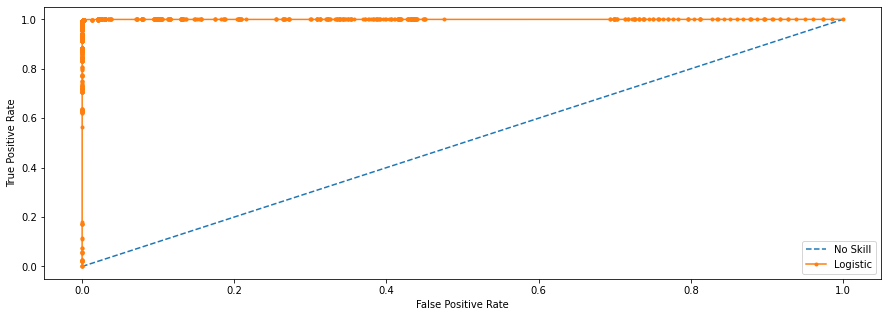

time: 1.76 s


In [47]:
# ROC curve for Random Forest Classifier and Naive Baye Classifier


from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

probability1 = [0 for _ in range(len(Y_test_dataframe))]

probability2 = model_2.predict_proba(X_test_dataframe)
probability2 = probability2[:, 1]

auc1 = roc_auc_score(Y_test_dataframe, probability1)
auc2 = roc_auc_score(Y_test_dataframe, probability2)

print('No Skill: ROC AUC=%.3f' % (auc1))
print('Logistic: ROC AUC=%.3f' % (auc2))

f_probability_1, t_probability_1, _ = roc_curve(Y_test_dataframe, probability1)
f_probability_2, t_probability_2, _ = roc_curve(Y_test_dataframe, probability2)

pyplot.plot(f_probability_1, t_probability_1, linestyle='--', label='No Skill')
pyplot.plot(f_probability_2, t_probability_2, marker='.', label='Logistic')

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

pyplot.legend()
pyplot.show()


No Skill: ROC AUC=0.500
Logistic: ROC AUC=1.000


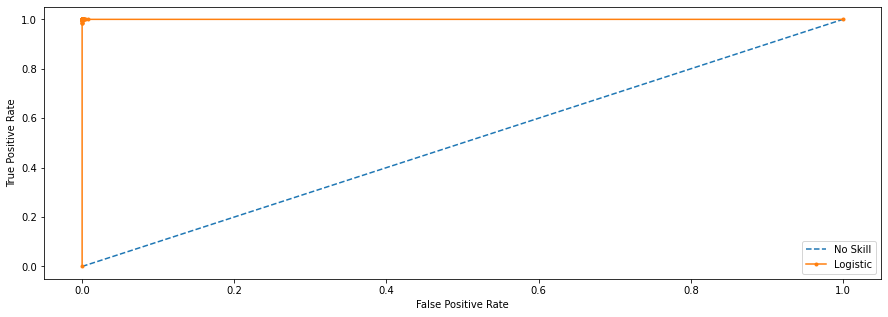

time: 1.36 s


In [48]:
# ROC curve for Random Forest Classifier

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

probability1 = [0 for _ in range(len(Y_test_dataframe))]

probability2 = Random_Forest_Classifier.predict_proba(X_test_dataframe)
probability2 = probability2[:, 1]

auc1 = roc_auc_score(Y_test_dataframe, probability1)
auc2 = roc_auc_score(Y_test_dataframe, probability2)

print('No Skill: ROC AUC=%.3f' % (auc1))
print('Logistic: ROC AUC=%.3f' % (auc2))

f_probability_1, t_probability_1, _ = roc_curve(Y_test_dataframe, probability1)
f_probability_2, t_probability_2, _ = roc_curve(Y_test_dataframe, probability2)

pyplot.plot(f_probability_1, t_probability_1, linestyle='--', label='No Skill')
pyplot.plot(f_probability_2, t_probability_2, marker='.', label='Logistic')

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

pyplot.legend()
pyplot.show()


No Skill: ROC AUC=0.500
Logistic: ROC AUC=1.000


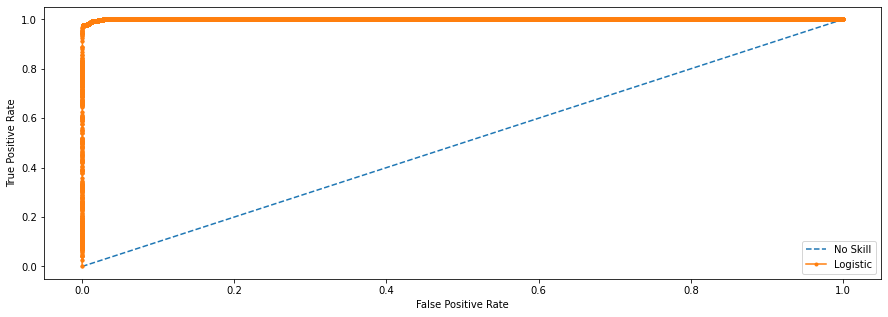

time: 18min 52s


In [49]:
# ROC curve for SVM Classifier

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.calibration import CalibratedClassifierCV

probability1 = [0 for _ in range(len(Y_test_dataframe))]

model_svc = SVC(random_state=0)
model = CalibratedClassifierCV(model_svc)
model.fit(X_train_dataframe, Y_train_dataframe)

probability2 = model.predict_proba(X_test_dataframe)
probability2 = probability2[:, 1]

auc1 = roc_auc_score(Y_test_dataframe, probability1)
auc2 = roc_auc_score(Y_test_dataframe, probability2)

print('No Skill: ROC AUC=%.3f' % (auc1))
print('Logistic: ROC AUC=%.3f' % (auc2))

f_probability_1, t_probability_1, _ = roc_curve(Y_test_dataframe, probability1)
f_probability_2, t_probability_2, _ = roc_curve(Y_test_dataframe, probability2)

pyplot.plot(f_probability_1, t_probability_1, linestyle='--', label='No Skill')
pyplot.plot(f_probability_2, t_probability_2, marker='.', label='Logistic')

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

pyplot.legend()
pyplot.show()


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.992


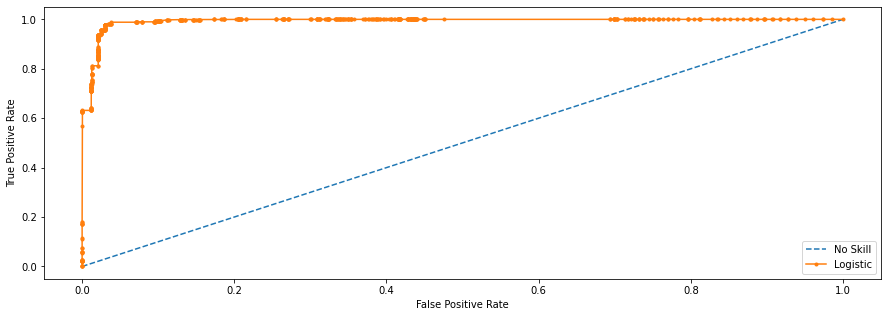

time: 576 ms


In [50]:
# ROC curve for Naive Baye Classifier



from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

probability1 = [0 for _ in range(len(Y_test_dataframe))]

probability2 = Naive_Baye_Classifier.predict_proba(X_test_dataframe)
probability2 = probability2[:, 1]

auc1 = roc_auc_score(Y_test_dataframe, probability1)
auc2 = roc_auc_score(Y_test_dataframe, probability2)

print('No Skill: ROC AUC=%.3f' % (auc1))
print('Logistic: ROC AUC=%.3f' % (auc2))

f_probability_1, t_probability_1, _ = roc_curve(Y_test_dataframe, probability1)
f_probability_2, t_probability_2, _ = roc_curve(Y_test_dataframe, probability2)

pyplot.plot(f_probability_1, t_probability_1, linestyle='--', label='No Skill')
pyplot.plot(f_probability_2, t_probability_2, marker='.', label='Logistic')

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

pyplot.legend()
pyplot.show()


No Skill: ROC AUC=0.500
Logistic: ROC AUC=1.000


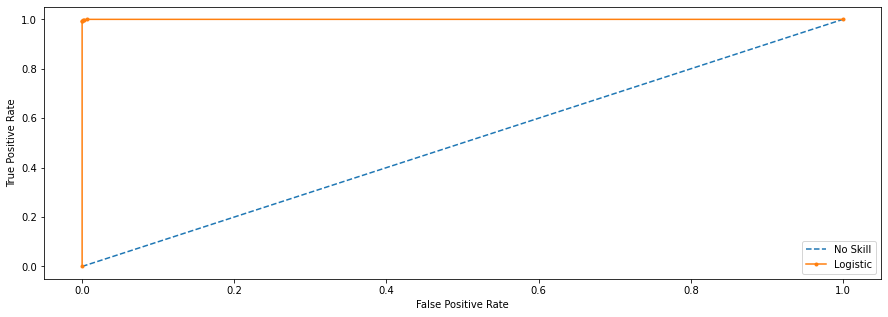

time: 1min 7s


In [51]:
# ROC curve for KNN Classifier


from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

probability1 = [0 for _ in range(len(Y_test_dataframe))]

probability2 = KNeighbors_Classifier.predict_proba(X_test_dataframe)
probability2 = probability2[:, 1]

auc1 = roc_auc_score(Y_test_dataframe, probability1)
auc2 = roc_auc_score(Y_test_dataframe, probability2)

print('No Skill: ROC AUC=%.3f' % (auc1))
print('Logistic: ROC AUC=%.3f' % (auc2))

f_probability_1, t_probability_1, _ = roc_curve(Y_test_dataframe, probability1)
f_probability_2, t_probability_2, _ = roc_curve(Y_test_dataframe, probability2)

pyplot.plot(f_probability_1, t_probability_1, linestyle='--', label='No Skill')
pyplot.plot(f_probability_2, t_probability_2, marker='.', label='Logistic')

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

pyplot.legend()
pyplot.show()


# Evaluating and Testing Models 


============================== Normal_DoS Random  Forest  Classifier   Model Evaluation ==============================

Model Accuracy:
 0.9999480272634127

Confusion matrix:

 [[67342     1]
 [    6 67337]]



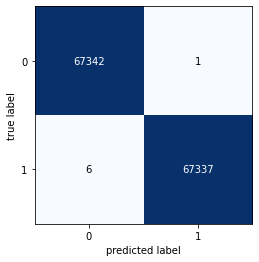


Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     67343
         1.0       1.00      1.00      1.00     67343

    accuracy                           1.00    134686
   macro avg       1.00      1.00      1.00    134686
weighted avg       1.00      1.00      1.00    134686



============================== Normal_DoS RFC and K-Neighbor Classifier Model Evaluation ==============================

Model Accuracy:
 0.9999257532334467

Confusion matrix:

 [[67343     0]
 [   10 67333]]



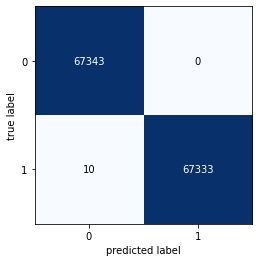


Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     67343
         1.0       1.00      1.00      1.00     67343

    accuracy                           1.00    134686
   macro avg       1.00      1.00      1.00    134686
weighted avg       1.00      1.00      1.00    134686



============================== Normal_DoS RFC & Naive Baye Classifier Model Evaluation ==============================

Model Accuracy:
 0.9984036945191037

Confusion matrix:

 [[67190   153]
 [   62 67281]]



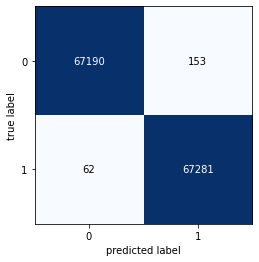


Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     67343
         1.0       1.00      1.00      1.00     67343

    accuracy                           1.00    134686
   macro avg       1.00      1.00      1.00    134686
weighted avg       1.00      1.00      1.00    134686



============================== Normal_DoS K-Nearest Neighbor Classifier Model Evaluation ==============================

Model Accuracy:
 0.9977577476500898

Confusion matrix:

 [[67287    56]
 [  246 67097]]



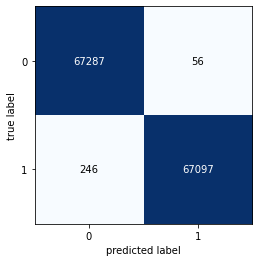


Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     67343
         1.0       1.00      1.00      1.00     67343

    accuracy                           1.00    134686
   macro avg       1.00      1.00      1.00    134686
weighted avg       1.00      1.00      1.00    134686



============================== Normal_DoS Support V-Machine Classifier Model Evaluation ==============================

Model Accuracy:
 0.9891376980532498

Confusion matrix:

 [[66345   998]
 [  465 66878]]



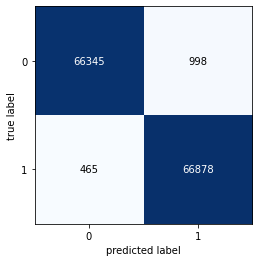


Classification report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     67343
         1.0       0.99      0.99      0.99     67343

    accuracy                           0.99    134686
   macro avg       0.99      0.99      0.99    134686
weighted avg       0.99      0.99      0.99    134686



============================== Normal_DoS Logistic Generalized Additive Model Evaluation ==============================

Model Accuracy:
 0.9844750011137015

Confusion matrix:

 [[65811  1532]
 [  559 66784]]



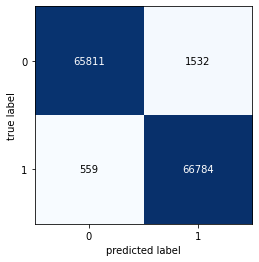


Classification report:
               precision    recall  f1-score   support

         0.0       0.99      0.98      0.98     67343
         1.0       0.98      0.99      0.98     67343

    accuracy                           0.98    134686
   macro avg       0.98      0.98      0.98    134686
weighted avg       0.98      0.98      0.98    134686



============================== Normal_DoS Naive  Baye's  Classifier    Model Evaluation ==============================

Model Accuracy:
 0.9737686173767133

Confusion matrix:

 [[65346  1997]
 [ 1536 65807]]



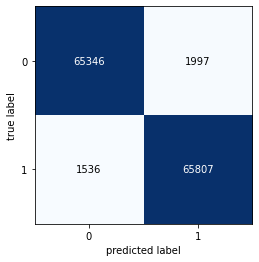


Classification report:
               precision    recall  f1-score   support

         0.0       0.98      0.97      0.97     67343
         1.0       0.97      0.98      0.97     67343

    accuracy                           0.97    134686
   macro avg       0.97      0.97      0.97    134686
weighted avg       0.97      0.97      0.97    134686


time: 11min 33s


In [52]:
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix

classifier = []

classifier.append(('Random  Forest  Classifier  ', Random_Forest_Classifier))
classifier.append(('RFC and K-Neighbor Classifier', model_1))
classifier.append(("RFC & Naive Baye Classifier", model_2))
classifier.append(('K-Nearest Neighbor Classifier', KNeighbors_Classifier))
classifier.append(('Support V-Machine Classifier', Support_vector_Classifier))
classifier.append(('Logistic Generalized Additive', Logistic_gam))
classifier.append(("Naive  Baye's  Classifier   ", Naive_Baye_Classifier))


for i, v in classifier:

    Accuracy = metrics.accuracy_score(Y_train_dataframe, v.predict(X_train_dataframe))
    Confusion_matrix = metrics.confusion_matrix(Y_train_dataframe, v.predict(X_train_dataframe))
    classification = metrics.classification_report(Y_train_dataframe, v.predict(X_train_dataframe))
    
    print()
    print('============================== {} {} Model Evaluation =============================='.format(group_class, i))
    print()
    print ("Model Accuracy:" "\n", Accuracy)
    print()
    print("Confusion matrix:\n" "\n", Confusion_matrix)
    print()
    fig, ax = plot_confusion_matrix(conf_mat=Confusion_matrix, figsize=(4, 4))
    plt.show()
    print()
    print("Classification report:" "\n", classification) 
    print()

In [53]:
print()
print('=================================== Model Test Results ===================================')
print('|                                           |                                             |')
print('|            MODELS                         |               ACCURACY                      |')
print('|          ----------                       |              ------------                   |')

for i, v in classifier:
    Accuracy = metrics.accuracy_score(Y_test_dataframe, v.predict(X_test_dataframe))
       
    print('|                                           |                                             |')
    print('|    {} Model                '.format(i), Accuracy,'                                      ')    
    print('|                                           |                                             |')
   
print('==========================================================================================')


=================================== Model Test Results ===================================
|                                           |                                             |
|            MODELS                         |               ACCURACY                      |
|          ----------                       |              ------------                   |
|                                           |                                             |
|    Random  Forest  Classifier   Model                 0.9999480272634127                                       
|                                           |                                             |
|                                           |                                             |
|    RFC and K-Neighbor Classifier Model                 0.9999257532334467                                       
|                                           |                                             |
|                                  

In [54]:
result = pd.DataFrame({'MODEL':['Random Forest Classifier Model','RFC and KNN Combined Model','RFC and Naive Bayes Combined Model','K-Nearest Neighbor Classifier Model','Support V-Machine Classifier Model','Logistic Generalized Additive Model','Naive Bayes Classifier Model'],
                   'Accuracy':[0.9999480272634127,0.9999257532334467,0.9984036945191037,0.9977577476500898,0.9891376980532498,0.9844750011137015,0.9737686173767133],
                   'Training Time':['12.5 s','19.3 s','12.5 s','3.35 s','2min 55s','36min 9s','183 ms']})

result

,MODEL,Accuracy,Training Time
0,Random Forest Classifier Model,0.999948,12.5 s
1,RFC and KNN Combined Model,0.999926,19.3 s
2,RFC and Naive Bayes Combined Model,0.998404,12.5 s
3,K-Nearest Neighbor Classifier Model,0.997758,3.35 s
4,Support V-Machine Classifier Model,0.989138,2min 55s
5,Logistic Generalized Additive Model,0.984475,36min 9s
6,Naive Bayes Classifier Model,0.973769,183 ms


time: 38.1 ms


In [55]:
excel_writer = pd.ExcelWriter('result.xlsx')
result.to_excel(excel_writer)
excel_writer.save()

time: 444 ms


In [56]:
from google.colab import files
files.download('result.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 5.22 ms
